In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
from source.interference_reject import InterferenceReject
from source.reader import read_raw
from source.gridding import NFFT
from source.combine import CoilCombo
from source.utils import compute_kspace_weights

%matplotlib inline

## Data import

In [2]:
file_name = "/Users/had-mr/github/yale_study/nr017_flair_trim.h5"
data, index, metadata = read_raw(file_name)
# Channel definitions
n_channels = metadata['console']['adc']['number_channels']
n_channels_signal = metadata['rf']['receive']['num_signal_channels']
select_channels_signal = np.arange(n_channels_signal)
select_channels_noise = np.arange(n_channels_signal, n_channels)
# Encoding
matrix_size = metadata['sequence']['encoding']['matrix_size']
k_x = index['scan']['encoding_1']
k_y = index['scan']['encoding_2']
k_2d = np.pi * np.vstack((k_x, k_y)).T

## Interference rejection

In [3]:
data_scan = data['scan']
n_lines, n_channels, n_readout = data_scan.shape
data_prescan = data['noise']
# Dynamic correction with k-space weighting
lines_per_bin = 100
num_bins = int(np.ceil(n_lines / lines_per_bin))
lines_per_bin = int(np.round(n_lines / num_bins))
bin_index = lines_per_bin * np.arange(num_bins)
bin_index = np.concatenate((bin_index, [n_lines - 1]))
interf_rej = InterferenceReject(channels_signal=select_channels_signal, channels_noise=select_channels_noise)
data_cor = np.zeros([n_lines, n_channels_signal, n_readout], dtype=np.complex64)
for _b in range(num_bins):
    sel_bin = slice(bin_index[_b], bin_index[_b + 1])
    data_bin = data_scan[sel_bin, :, :]
    k_weights = compute_kspace_weights(k_coords=k_2d[sel_bin, :], n_readout=n_readout, n_channels=n_channels)
    data_cor[sel_bin, :, :] = interf_rej.apply(data_signal=data_bin, data_noise=k_weights * data_bin)


## Fourier reconstruction

In [4]:
# Apply readout FT
spec_cor = np.fft.fftshift(np.fft.fft(data_cor, axis=-1), axes=-1)
# Apply non-uniform FT
encode_op = NFFT(k_coords=k_2d, image_size=matrix_size[1:], n_channels=n_channels_signal)
dims_4d = np.concatenate((matrix_size, [n_channels_signal]))
im4d_cor = np.zeros(dims_4d, dtype=np.complex64)
for _f in range(spec_cor.shape[-1]):
    im4d_cor[_f, :, :, :] = encode_op.adjoint(spec_cor[:, :, _f])
np.save("image_coil.npy", im4d_cor)

## Coil combine

In [7]:
# Get data for prewhitening using weighted k-space
k_weights = compute_kspace_weights(k_coords=k_2d, n_readout=n_readout, n_channels=n_channels_signal, threshold=0.8)
data_weighted = data_cor * k_weights

comb_complex = CoilCombo(matrix_size=matrix_size, size_patch=[6, 6, 3])
im_sos = comb_complex.forward(im4d_cor, data_noise=None, flag_prewhite=False, mode='SoS')
im_adapt = comb_complex.forward(im4d_cor, data_noise=data_weighted, flag_prewhite=False, mode='adaptive')

Interpolate dimension 0 from 112 to 114
Interpolate dimension 1 from 136 to 138


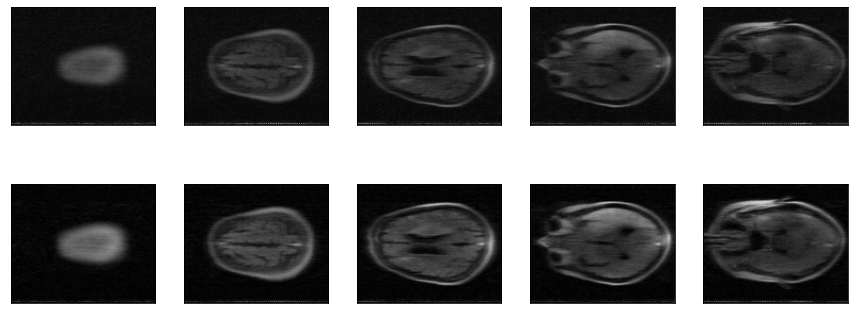

In [8]:
# Plot data
slc = 17
max_scale = 10
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15,6))
for _frame in range(0,5):
    ax[0, _frame].imshow(np.abs(im_sos[:, :, 5 + _frame*5]), cmap='gray', vmin=0, vmax=max_scale * np.mean(np.abs(im_sos)))
    ax[0, _frame].set_xticks([])
    ax[0, _frame].set_yticks([])
for _frame in range(0,5):
    ax[1, _frame].imshow(np.abs(im_adapt[:, :, 5 + _frame*5]), cmap='gray', vmin=0, vmax=max_scale * np.mean(np.abs(im_adapt)))
    ax[1, _frame].set_xticks([])
    ax[1, _frame].set_yticks([])

# fig.savefig("methods_rejection_image.tif", dpi=600, format="tiff")
fig.savefig("methods_coil_combine.png")